In [13]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pyLDAvis.gensim
import pyLDAvis
from pprint import pprint
import spacy
import logging
import warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
nltk.download('stopwords')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tudorpescaru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
publications_df = pd.read_csv('publications-converted.csv', quotechar="'", delimiter=',', quoting=2)
authors_df = pd.read_csv('authors_all.csv')
users_df = pd.read_csv('users_all.csv')

publications_df = publications_df.drop(columns=['id', 'no_coauthors', 'publication_type', 'no_pages', 'd_oi', 
                                                'category', 'file_link', 'external_link', 'publisher', 'w_os',
                                                'jhi_type', 'cross_ref_validation', 'publication_date',
                                                'file_link_shown', 'citations_number', 'metadata', 'internal_link',
                                                'keywords_valid', 'photo_link', 'mapped_to_id', 'local_keywords',
                                                'keywords_isi'])
publications_df = publications_df.dropna(subset=['title', 'abstract_text', 'keywords'])
langs = publications_df['abstract_lang'].unique()
print("\nStarting languages: ", langs)
# Only one publication in 'UNKNOWN' language and it is in english
publications_df.loc[publications_df['abstract_lang'] == 'UNKNOWN', 'abstract_lang'] = 'en'
# Drop publications with no abstract language
publications_df = publications_df.dropna(subset=['abstract_lang'])
langs = publications_df['abstract_lang'].unique()
print("\nUsed languages: ", langs)

# Group publications by language
publications_df = publications_df.groupby('abstract_lang')

publications_en = publications_df.get_group('en')
publications_ro = publications_df.get_group('ro')

publications_en = publications_en.drop(columns=['abstract_lang'])
publications_ro = publications_ro.drop(columns=['abstract_lang'])


Starting languages:  ['en' nan 'ro' 'UNKNOWN' 'id' 'fr' 'it' 'de']

Used languages:  ['en' 'ro' 'id' 'fr' 'it' 'de']


In [25]:
def cleanup_text(texts):
    # Remove punctuation, newlines and tabs
    texts = texts.map(lambda x: re.sub('[,\\.!?`\'\n\t•„"]', '', x))
    # Remove numbers
    texts = texts.map(lambda x: re.sub('[0-9]', '', x))
    # Convert to lowercase
    texts = texts.map(lambda x: x.lower())
    return texts

publications_en['abstract_text_processed'] = cleanup_text(publications_en['abstract_text'])
print(publications_en['abstract_text_processed'].head())
publications_ro['abstract_text_processed'] = cleanup_text(publications_ro['abstract_text'])
print(publications_ro['abstract_text_processed'].head())

1     a fluoride ion selective electrode was develop...
2     natural fibrous polymers were chemically modif...
3     dislipidemy is one of the frequently diagnosed...
7     a search for lightly ionizing particles has be...
11    in a recent report in matter zhu wang he and c...
Name: abstract_text_processed, dtype: object
54      numita conditia de normare a functiei de dens...
417    rezumat lucrarea abordează comportarea unui mo...
461    această lucrare vizează un domeniu de actualit...
691    progresul în domeniul ştiinei şi ingineriei av...
714    creativitatea este capacitatea de a produce id...
Name: abstract_text_processed, dtype: object


In [26]:
stop_words_en = stopwords.words('english')
stop_words_en.extend(['from', 'subject', 're', 'edu', 'use', 'result'])
stop_words_ro = stopwords.words('romanian')
stop_words_ro.extend(['tip'])

def split_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def build_bigram_trigram_models(data_words):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words_en, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    return bigram_mod, trigram_mod

def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts, bigram_mod, trigram_mod):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# tokenize
data_en = publications_en['abstract_text_processed'].values.tolist()
data_words_en = list(split_words(data_en))

# tokenize
data_ro = publications_ro['abstract_text_processed'].values.tolist()
data_words_ro = list(split_words(data_ro))

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp_en = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
# Initialize spacy 'ro' model, keeping only tagger component (for efficiency)
# python3 -m spacy download ro_core_news_sm
nlp_ro = spacy.load('ro_core_news_lg', disable=['parser', 'ner'])

# lemmatization
data_words_en = lemmatization(data_words_en, nlp_en)
# lemmatization
data_words_ro = lemmatization(data_words_ro, nlp_ro)

# remove stop words
data_words_en = remove_stopwords(data_words_en, stop_words_en)
# remove stop words
data_words_ro = remove_stopwords(data_words_ro, stop_words_ro)

bigram_mod_en, trigram_mod_en = build_bigram_trigram_models(data_words_en)
bigram_mod_ro, trigram_mod_ro = build_bigram_trigram_models(data_words_ro)

# form bigrams
data_words_en = make_bigrams(data_words_en, bigram_mod_en)
# form bigrams
data_words_ro = make_bigrams(data_words_ro, bigram_mod_ro)

print(data_words_en[:1])
print(data_words_ro[:1])

[['fluoride', 'ion', 'selective', 'electrode', 'develop', 'base', 'uranyl', 'salophenes', 'derivative', 'basic', 'electrode', 'performance', 'characteristic', 'evaluate', 'optimize', 'sensor', 'respond', 'linearly', 'concentration', 'run', 'slope', 'mv', 'decade', 'electrode', 'show', 'good', 'selectivity', 'sulfate', 'chloride', 'nitrate', 'measuring', 'perform', 'suggest', 'electrode', 'determination', 'fluoride', 'groundwater', 'certain', 'range', 'concentration']]
[['conditie', 'normare', 'functie', 'densitate', 'probabilitate', 'geometric', 'conditie', 'arie', 'subgrafic', 'functie', 'densitate', 'probabilitate', 'trebui', 'unitara', 'conditie', 'esential', 'verifica', 'functie', 'densitate', 'probabilitate']]


In [27]:
def display_wordcloud(data_words):
    # Join the different processed titles together.
    long_string = ','.join([word for sublist in data_words for word in sublist])
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=800, height=600)
    # Generate a word cloud
    wordcloud.generate(long_string)
    return wordcloud

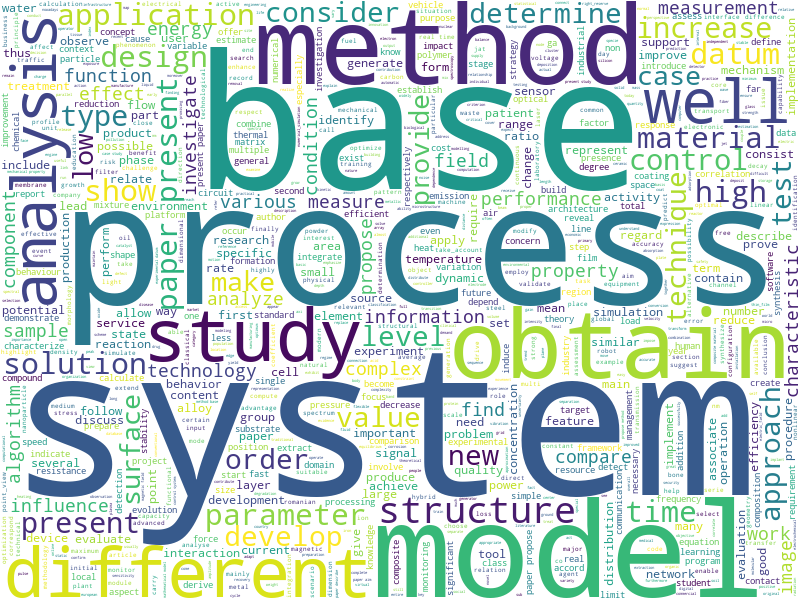

In [28]:
display_wordcloud(data_words_en).to_image()

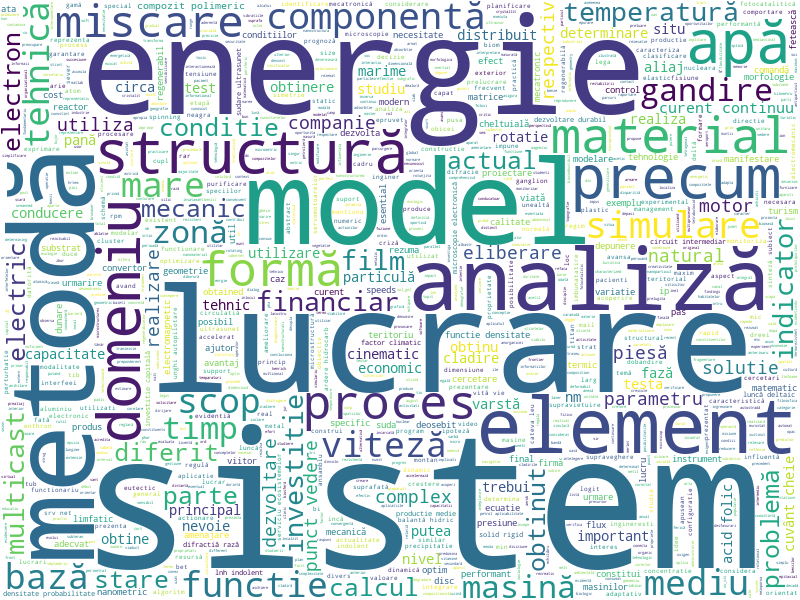

In [29]:
display_wordcloud(data_words_ro).to_image()

In [30]:
# Create Dictionary
id2word_en = corpora.Dictionary(data_words_en)
id2word_ro = corpora.Dictionary(data_words_ro)
# Create Corpus
texts_en = data_words_en
texts_ro = data_words_ro
# Term Document Frequency
corpus_en = [id2word_en.doc2bow(text) for text in texts_en]
corpus_ro = [id2word_ro.doc2bow(text) for text in texts_ro]
# View
print(corpus_en[:1])
print(corpus_ro[:1])

# Human readable format of corpus (term-frequency)
print([[(id2word_en[id], freq) for id, freq in cp] for cp in corpus_en[:1]])
print([[(id2word_ro[id], freq) for id, freq in cp] for cp in corpus_ro[:1]])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 4), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]]
[[(0, 1), (1, 3), (2, 3), (3, 1), (4, 3), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('base', 1), ('basic', 1), ('certain', 1), ('characteristic', 1), ('chloride', 1), ('concentration', 2), ('decade', 1), ('derivative', 1), ('determination', 1), ('develop', 1), ('electrode', 4), ('evaluate', 1), ('fluoride', 2), ('good', 1), ('groundwater', 1), ('ion', 1), ('linearly', 1), ('measuring', 1), ('mv', 1), ('nitrate', 1), ('optimize', 1), ('perform', 1), ('performance', 1), ('range', 1), ('respond', 1), ('run', 1), ('salophenes', 1), ('selective', 1), ('selectivity', 1), ('sensor', 1), ('show', 1), ('slope', 1), ('suggest', 1), ('sulfate', 1), ('uranyl', 1)]]
[[('arie', 

In [40]:
# number of topics
num_topics = 10
chunksize = 2000
passes = 5
alpha = 'asymmetric'
# eta = 'auto'
eta = 0.0001
iterations = 200
eval_every = 1
# Build LDA model
lda_model_en = gensim.models.LdaMulticore(
    corpus=corpus_en,
    id2word=id2word_en,
    num_topics=num_topics,
    chunksize=chunksize,
    passes=passes,
    alpha=alpha,
    eta=eta,
    eval_every=eval_every,
    iterations=iterations,
)
lda_model_ro = gensim.models.LdaMulticore(
    corpus=corpus_ro,
    id2word=id2word_ro,
    num_topics=num_topics,
    chunksize=chunksize,
    passes=passes,
    alpha=alpha,
    eta=eta,
    eval_every=eval_every,
    iterations=iterations,
)
# Print the Keyword in the 10 topics
pprint(lda_model_en.print_topics())
doc_lda_en = lda_model_en[corpus_en]
pprint(lda_model_ro.print_topics())
doc_lda_ro = lda_model_ro[corpus_ro]

[(0,
  '0.008*"study" + 0.007*"present" + 0.007*"system" + 0.007*"paper" + '
  '0.007*"model" + 0.006*"base" + 0.006*"process" + 0.005*"datum" + '
  '0.005*"well" + 0.005*"high"'),
 (1,
  '0.010*"high" + 0.007*"paper" + 0.007*"present" + 0.007*"image" + '
  '0.006*"process" + 0.006*"alloy" + 0.006*"material" + 0.006*"base" + '
  '0.005*"time" + 0.005*"obtain"'),
 (2,
  '0.008*"temperature" + 0.007*"model" + 0.007*"paper" + 0.007*"obtain" + '
  '0.006*"method" + 0.006*"study" + 0.006*"present" + 0.006*"material" + '
  '0.006*"base" + 0.005*"different"'),
 (3,
  '0.008*"method" + 0.006*"system" + 0.006*"present" + 0.006*"base" + '
  '0.005*"paper" + 0.005*"datum" + 0.005*"process" + 0.005*"image" + '
  '0.005*"energy" + 0.004*"study"'),
 (4,
  '0.008*"patient" + 0.006*"study" + 0.006*"system" + 0.006*"concentration" + '
  '0.005*"surface" + 0.005*"energy" + 0.005*"time" + 0.005*"show" + '
  '0.004*"obtain" + 0.004*"value"'),
 (5,
  '0.007*"present" + 0.006*"paper" + 0.005*"material" + 0.

In [32]:
# Compute Perplexity
print('\nPerplexity for EN: ', lda_model_en.log_perplexity(corpus_en))  # a measure of how good the model is. lower the better.
print('\nPerplexity for RO: ', lda_model_ro.log_perplexity(corpus_ro))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_en = CoherenceModel(model=lda_model_en, texts=data_words_en, dictionary=id2word_en, coherence='c_v')
coherence_lda_en = coherence_model_lda_en.get_coherence()
print('\nCoherence Score for EN: ', coherence_lda_en)
coherence_model_lda_ro = CoherenceModel(model=lda_model_ro, texts=data_words_ro, dictionary=id2word_ro, coherence='c_v')
coherence_lda_ro = coherence_model_lda_ro.get_coherence()
print('\nCoherence Score for RO: ', coherence_lda_ro)


Perplexity for EN:  -8.077108578121845

Perplexity for RO:  -7.113130643793632

Coherence Score for EN:  0.30701818344749265

Coherence Score for RO:  0.40654021548784175


In [34]:
lda_model = lda_model_en
corpus = corpus_en
id2word = id2word_en

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.068457  0.023149       1        1  21.366745
1      0.007558  0.042591       2        1  17.921270
0     -0.053742  0.007430       3        1  16.805110
3     -0.058134  0.011021       4        1  10.903873
2      0.078297  0.052064       5        1   7.645084
5     -0.067166  0.007336       6        1   7.120877
6      0.014062  0.033110       7        1   6.531635
8     -0.101254 -0.036769       8        1   4.848149
7      0.049117 -0.010916       9        1   4.012027
9      0.062805 -0.129016      10        1   2.845229, topic_info=          Term         Freq        Total Category  logprob  loglift
78      system  2388.000000  2388.000000  Default  30.0000  30.0000
60    material   964.000000   964.000000  Default  29.0000  29.0000
1452     alloy   320.000000   320.000000  Default  28.0000  28.0000
425      power   749.000000   749.000000  Default  27.0000  27.0000
143    patient   364.000000   364.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
527     obtain    20.307486  1278.413573  Topic10  -6.0844  -0.5829
614       well    19.776297   934.777293  Topic10  -6.1110  -0.2963
618   analysis    19.825573  1135.695274  Topic10  -6.1085  -0.4885
426    process    19.723938  1377.373549  Topic10  -6.1136  -0.6866
97     control    19.393260   913.036073  Topic10  -6.1305  -0.2923

[895 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1040       4  0.154346         aa
1040      10  0.771728         aa
13370      6  0.148977    abandon
13370      7  0.744887    abandon
15596      2  0.844218  abductive
...      ...       ...        ...
959        3  0.307979    zeolite
959        4  0.092394    zeolite
959        6  0.492766    zeolite
959        7  0.061596    zeolite
15034      7  0.710518     zigzag

[2954 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3, 6, 7, 9, 8, 10])